In [38]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import imageio
from Cython.Includes.numpy import ndarray
from IPython.display import Video
from typing import Sequence, Tuple, Any

import warnings
from numba import njit,jit,prange

from numba import cuda
from numpy import ndarray

warnings.filterwarnings("ignore")
import numpy.core.numeric as _nx

In [300]:
dt = 0.00001
vMax = 1
length = 200
N = 100
sigma = 1
epsilon =1
bigSteps = 1000
smallSteps = 10000
rMag = None
p = None
#myFilter = None
myFilter =True
leftSideTrajectory = None
uTrajectory = None
pressureTrajectory = None
xTrajectory = None
tempTrajectory = None
vTrajectory = None
energyTrajectory = None
length = length
N = N
vMax = vMax
epsilon = epsilon
sigma = sigma
rc = 2.5 * sigma
distances = None


a = int(1/(1/(2*N))**(1/2))
# creating available positions based on a
X = np.zeros((len( np.linspace(0,1,a+1)) * len(np.linspace(0,0.5,a//2)),2))
for i,j in enumerate(itertools.product( np.linspace(0.1,0.9,a+1),np.linspace(0,0.5,a//2))):
    X[i] = j

x = length * X[:N,:] 


# randomly initializing velocities
v = np.random.random((N,2))
v -= np.mean(v , axis= 0 )
v *= vMax

In [301]:
T = getK(v)

In [302]:
@njit
def tile(x):
    tiled = np.zeros((N,N,2))
    for i in range(N):
        tiled[i,:,:] = x
        
    return tiled

In [303]:
@njit
def getDistanceMatrix(A):
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    distances = ((distances + length/2) % length - length/2)
    return distances

In [304]:
@njit
def getLeftSidedNum(x) -> np.ndarray:
    return np.sum(x[:,1]<=length/2)

In [305]:

@njit
def getK(v) -> np.ndarray:
        return np.sum(np.square(v))/2

In [306]:
def animate(trajectory: np.ndarray, name: str,jump) -> None:
    images = []
    for i in range(len(trajectory)//jump):
        plt.clf()
        plt.title("Animating md Model for bigSteps={0} size={1}".format(len(trajectory),length))
        plt.scatter(trajectory[i*jump,:,0],trajectory[i*jump,:,1],c="blue",s=1)
        plt.xlim((0,length))
        plt.ylim((0,length))
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.savefig(str(i)+".png")
        images.append(imageio.imread(str(i)+".png"))

    imageio.mimsave('{}.mp4'.format(name), images)
    Video('{}.mp4'.format(name))


In [307]:
@njit
def getRebounded(xNew: np.ndarray) -> np.ndarray:
    return xNew % length

@njit
def getU(rMag) -> np.ndarray:
    Us = 4*epsilon*(sigma / (rMag) ** 12 - (sigma / (rMag) ** 6))
    Us = np.where(np.isnan(Us),0,Us)  # ignoring where U explodes for example U(rii)
    return np.sum(Us*myFilter)/2


In [308]:
@njit
def getAutoCorrelation(Array: np.array, j: int) -> np.ndarray:
    autoCor = np.mean(Array[:-j] * Array[j:]) - np.mean(Array[:-j] ** 2)
    autoCor /=  np.var(Array)
    return autoCor   

In [309]:
@njit
def getAcceleration(forces) -> np.ndarray:
    #ljForce(getDistanceMatrix()
    return np.sum(forces,axis=1)  #???


def getCorrelationLength(vTrajectory) -> Sequence:
    autoCorrelation = np.zeros(bigSteps)
    for j in np.arange(1,bigSteps):
        auto = 0
        for n in range(0,N):
            auto += getAutoCorrelation(vTrajectory[:,n].real,j)
            auto += getAutoCorrelation(vTrajectory[:,n].imag,j)

        autoCorrelation[j] = auto/(2*N)
    return (1+autoCorrelation),len((1+autoCorrelation)[(1+autoCorrelation) > np.exp(-1)])

In [310]:
@njit
def ljForce(r: np.ndarray,v) -> tuple[Any, Any, Any, Any, Any]:
    squareDistances = np.square(r)
    
    rMag = np.sqrt(np.sum(squareDistances,axis=2))  # magnitude of r
    #myFilter = (rMag < rc)  #filtering the far particles
    myFilter = True

    f = np.zeros(r.shape)
    f[:,:,0] = -24 * epsilon * (2 * (sigma / rMag)**14 - (sigma / rMag)**8) *r[:,:,0]*myFilter
    f[:,:,1] = -24 * epsilon * (2 * (sigma / rMag)**14 - (sigma / rMag)**8) *r[:,:,1]*myFilter
    
  

    f = np.where(np.isnan(f),0,f)  # deleting the f where isnan for example rii = 0
    


    #claculating pressure
    fDotR = np.sum(f * r)
    T = getK(v)
    p = (N*T + fDotR) / (2*length**2)
    

    return f,rMag,myFilter,T,p



In [311]:
distances = getDistanceMatrix(x)

In [312]:
f,rMag,myFilter,T,p = ljForce(distances,v)

In [313]:
@njit
def velocityVerlet(x,v,a,dt: float) -> tuple[Any, Any, Any]:

    vNew = v + 0.5 * a * dt # update velocities
    xNew = (x + vNew * dt) # update positions
    x = getRebounded(xNew)



     
    distances = getDistanceMatrix(x)
    forces , rMag,myfilter ,T,P = ljForce(distances,v)
    
    aNew = getAcceleration(forces)
    vNew = vNew + 0.5 * aNew * dt # update velocities
    
    
    v = vNew
    v -= np.mean(v)  # resetting Vcm
    a = aNew
    
    return x,v,a,rMag,myfilter,T,P

In [314]:
x,v,a,rMag,myFilter,T,P = velocityVerlet(x,v,a,dt)

In [315]:
myFilter

True

In [316]:
def run(x,v,a):
    #initializing the trajectories
    energyTrajectory = np.zeros(bigSteps)
    xTrajectory = np.zeros((bigSteps,N,2))
    vTrajectory = np.zeros((bigSteps,N,2))
    tempTrajectory = np.zeros(bigSteps)
    pressureTrajectory = np.zeros(bigSteps)
    uTrajectory = np.zeros(bigSteps)
    leftSideTrajectory = np.zeros(bigSteps)

        #main loop
    for i in range(bigSteps):
        print(i)  #to see the process is running

        for j in range(smallSteps):
            x,v,a,rMag,myfilter,T,P = velocityVerlet(x,v,a,dt)

        #storing data
        U = getU(rMag)
        T =  getK(v)
        leftSideTrajectory[i]  = getLeftSidedNum(x)

        xTrajectory[i]  = x
        vTrajectory[i]  = v
        
        tempTrajectory[i]  = T
        pressureTrajectory[i]  = p
        uTrajectory[i]  = U
        energyTrajectory[i] = T + U
        


    return xTrajectory,vTrajectory,tempTrajectory,pressureTrajectory,uTrajectory,energyTrajectory,leftSideTrajectory


In [317]:
myFilter

True

In [ ]:
xTrajectory,vTrajectory,tempTrajectory,pressureTrajectory,uTrajectory,energyTrajectory,leftSideTrajectory = run(x,v,a)

0
1
2
3
4


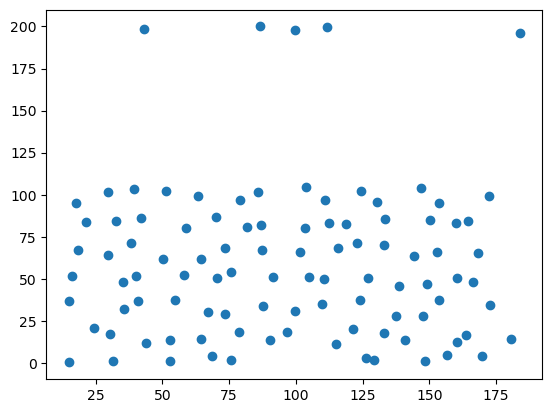

In [298]:
plt.scatter(xTrajectory[-1,:,0],xTrajectory[-1,:,1])

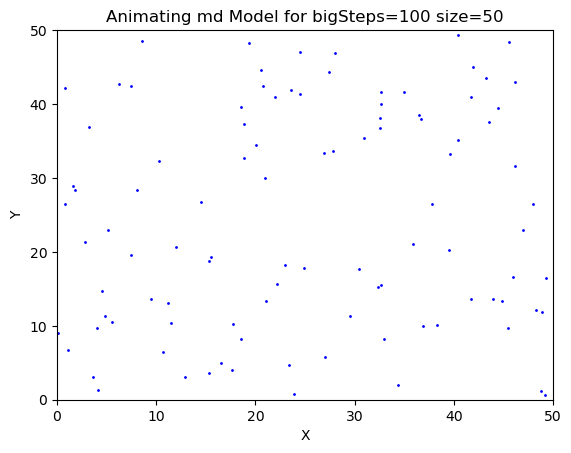

In [37]:
animate(xTrajectory,"part0_1",1)

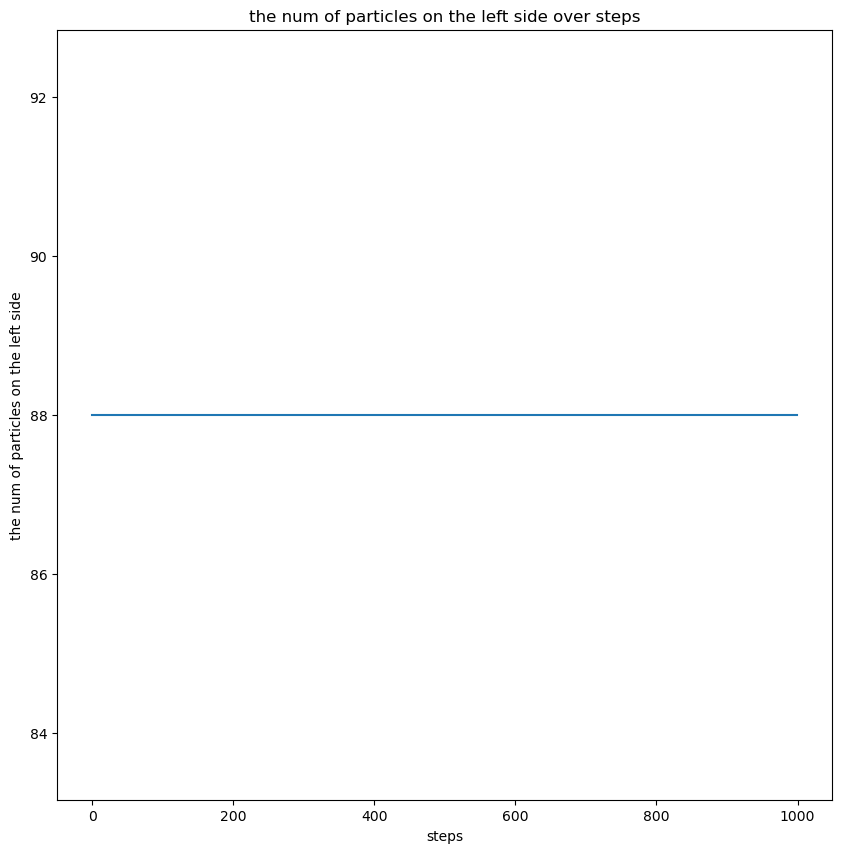

In [299]:
plt.figure(figsize=(10,10))
plt.title("the num of particles on the left side over steps")
plt.xlabel("steps")
plt.ylabel("the num of particles on the left side")
plt.plot(np.arange(bigSteps),leftSideTrajectory)
plt.show()

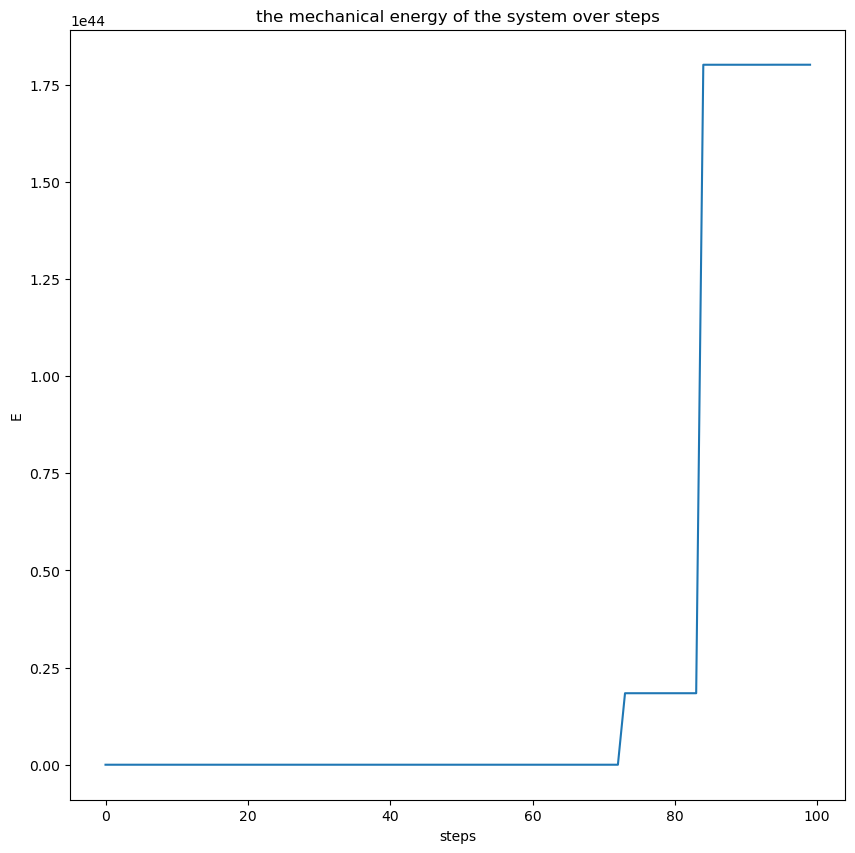

In [31]:
plt.figure(figsize=(10,10))
plt.title("the mechanical energy of the system over steps")
plt.xlabel("steps")
plt.ylabel("E")
plt.plot(np.arange(bigSteps),energyTrajectory)
plt.show()

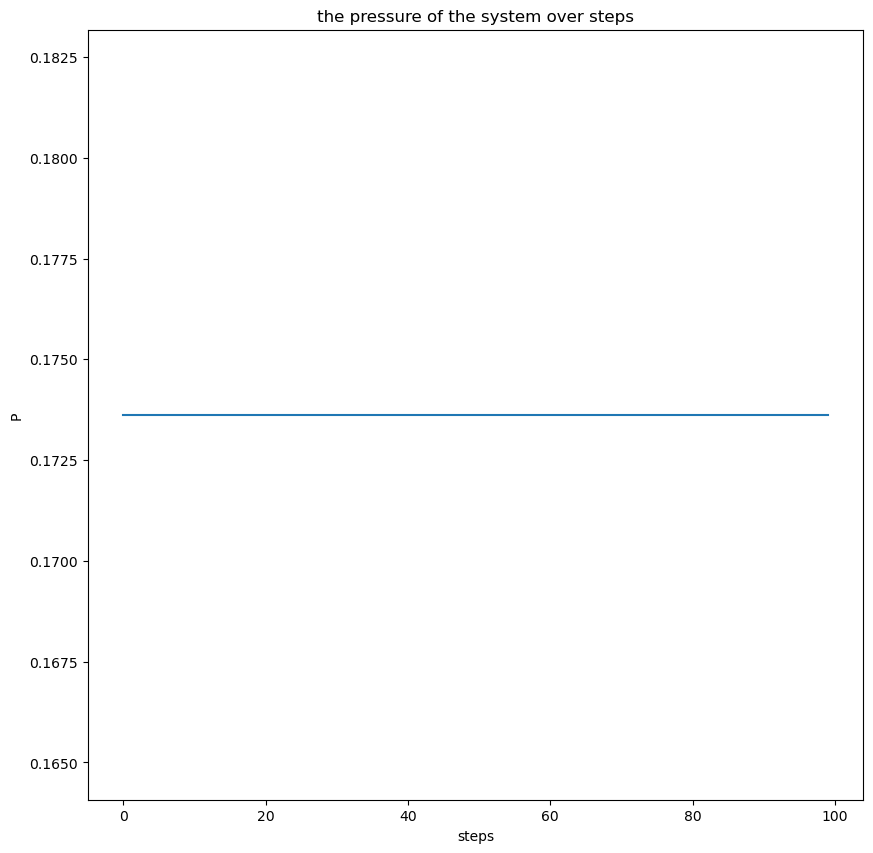

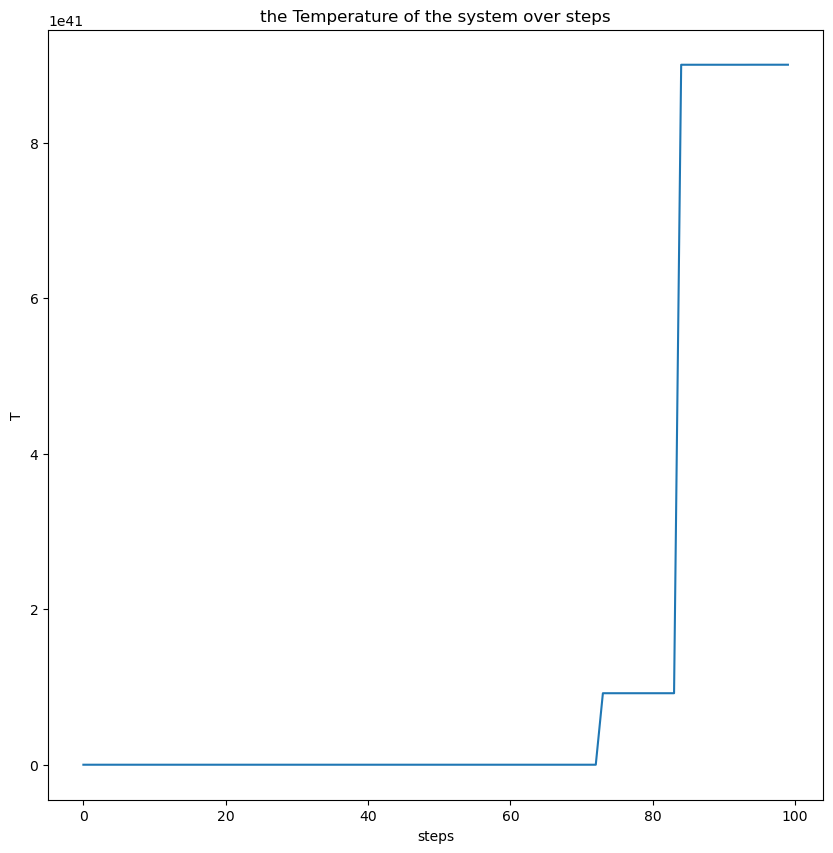

T =  1.5420997507343416e+41
P =  0.1736251350705678


In [33]:
plt.figure(figsize=(10,10))
plt.title("the pressure of the system over steps")
plt.xlabel("steps")
plt.ylabel("P")
plt.plot(np.arange(bigSteps),pressureTrajectory[:bigSteps])
plt.show()

plt.figure(figsize=(10,10))
plt.title("the Temperature of the system over steps")
plt.xlabel("steps")
plt.ylabel("T")
plt.plot(np.arange(bigSteps),tempTrajectory[:bigSteps]/(2*N))
plt.show()

print("T = ",np.mean(tempTrajectory[:bigSteps])/(2*N))
print("P = ",np.mean(pressureTrajectory[:bigSteps]))

In [34]:
m,p0 = np.polyfit(tempTrajectory[:bigSteps],pressureTrajectory[:bigSteps]/(2*N),1)

a = - p0 * (length**2 / N) ** 2
b = (length**2 / N) - 1/(6.02 * 10**23)
print("a = {0} and b = {1}".format(a,b))

a = -0.5425785470955243 and b = 25.0
